### Install libraries

In [ ]:
# Install all important libraries
!pip install yfinance
!pip install ta

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 1.7 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for ta: filename=ta-0.10.2-py3-none-any.whl size=29106 sha256=ff020816d7c77f75cd9f680ccf466f90f9e1b6584e9c2413c1480c655af825e2
  Stored in directory: /root/.cache/pip/wheels/31/31/f1/f2ff471bbc5b84a4b973698ceecdd453ae043971791adc3431
Successfully built ta


In [ ]:
# import all libraries

from ta.utils import dropna
from ta.volatility import BollingerBands
from ta.trend import macd, macd_signal
from ta.volatility import AverageTrueRange
from ta.trend import SMAIndicator
from ta.momentum import RSIIndicator
from ta.volume import VolumeWeightedAveragePrice

import math
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt

import warnings

warnings.filterwarnings('ignore')

# Out-of-Sample Backtester Project

## Members:
- Brendan Chia
- Ng Xiang Han
- Noah Teo Rui-Sheng
- Vanshiqa Agrawal

## Strategy: Bollinger Bands (BB) + Relative Strength Index (RSI)
This strategy aims to capitalise on the momentum of certain stocks. BB and RSI are momentum technical indicators that can help to enter a trend from the stock is picking up steam. When a long or short signal is triggered, it suggests that a new trend is developing.

## Position and Risk Management
This strategy leveraged on Average True Range (ATR) indicator to create a reasonable Stop Loss price. Creating a Stop Loss allows the strategy to cut its losses when entering a bad trade. This allows its keep most of its capital for future trading. The Stop Loss price can be manually set by the user by inputting an integer as an ATR Multiplier to increase the price difference of the current price and Stop Loss price.

Also, this strategy plans how much it is willing to lose per trade. With the Stop Loss price set, the strategy is able to deduce the position it will take when entering into a trade. The amount of capital the strategy is willing to lose is a variable the user can manually set as a percentage. To add on, the strategy is given portfolio weights to distribute the initial capital for each stock according to the inputted weights.

## Signal, Parameters and Variables
### Go LONG
- 14 Day RSI is above 60
- 14 Day BB is above 1 S.D

### Go LONG
- 14 Day RSI is below 40
- 14 Day BB is below 1 S.D

### Stop Loss Parameter and Variable
14 Day ATR

## Training and Testing Period
This strategy is trained with data from 2010 to 2015. After that, it is tested for 4 years from 2016 to 2019.


## Common class

In [ ]:
class Common_Class():  

  def __init__(self, symbol, weights, max_loss_percentage, start, end, interval, capital, transaction_cost, verbose = True):
    self.all_data = {}
    self.all_positions = {}
    self.all_signals = {}
    self.all_quantities = {}
    self.max_loss_percentage = max_loss_percentage
    self.all_symbols = symbol
    self.all_trades = {}
    self.all_weights = {}
    self.all_stored_trade_data = {}
    self.all_stored_daily_data = {}
    self.all_stop_loss_price = {}
    self.capital = {}
    self.initial_capital = {}
    index = 0
    self.portfolio_results = pd.DataFrame()

    for stock in self.all_symbols:
      self.all_weights[stock] = weights[index]
      self.initial_capital[stock] = capital * weights[index]
      self.capital[stock] = self.initial_capital[stock]      
      index += 1
      self.all_positions[stock] = 0
      self.all_signals[stock] = 0
      self.all_quantities[stock] = 0
      self.all_trades[stock] = 0
      self.all_stop_loss_price[stock] = 0
      self.all_stored_trade_data[stock] = pd.DataFrame(columns=["trade", "date", "position", "price", "symbol", "quantity", "capital"])
      self.all_stored_daily_data[stock] = pd.DataFrame(columns=["trade", "date", "position", "price", "symbol", "quantity", "capital"])
      
    self.start = start
    self.end = end
    self.interval = interval
    self.transaction_cost = transaction_cost
    self.verbose = verbose
    
    self.prepare_data()

  def prepare_data(self):
    for stock in self.all_symbols:
      stock_data = yf.Ticker(stock)
      hist_stock = stock_data.history(start = self.start, end = self.end, interval = self.interval)
      bt_data = pd.DataFrame()
      bt_data["Close_Price"] = hist_stock["Close"]
      bt_data["High_Price"] = hist_stock["High"]
      bt_data["Low_Price"] = hist_stock["Low"]
      bt_data["Return"] = np.log(bt_data["Close_Price"] / bt_data["Close_Price"].shift(1))
      bt_data = bt_data.dropna()

      # Get Market Data [Benchmark]
      market_data = yf.Ticker("^GSPC")
      market_stock = market_data.history(start = self.start, end = self.end, interval = self.interval)
      bt_data["Benchmark_Price"] = market_stock["Close"]
      bt_data['Benchmark_Returns'] = np.log(bt_data["Benchmark_Price"] / bt_data["Benchmark_Price"].shift(1))
      bt_data = bt_data.dropna()
      self.all_data['{}'.format(stock)] = bt_data
  
  def close_graph(self):
    for stock in self.all_symbols:
      plt.figure(figsize=(15, 5))
      plt.plot(self.all_data[stock]["Close_Price"], color='black', label='Price', linestyle='dashed')
      plt.xlabel("Days")
      plt.ylabel("Price")
      plt.title("Close Prices of {}".format(stock))
      plt.legend()
      plt.grid()
      plt.show()

  def return_date_price(self, bar, stock):
    # A bar is a unit of data at a given time, depends on the interval you choose, it provides you OHLCV and time info
    # Since we have modeled close prices, we will get the price and date
    date = self.all_data[stock].index[bar]
    price = self.all_data[stock].Close_Price.iloc[bar]
    return date, price

  def realised_balance(self, bar):
    print("--- Realised Balance ---")
    # Returns you the realised capital in your account at a given time period / bar
    rb = 0
    for stock in self.all_symbols:
      date, price = self.return_date_price(bar, stock)
      rb += self.capital[stock]
      print("Date: {}, Price: {:0.2f} | Realised Balance for {} Stock: {:0.2f}".format(date, price, stock, self.capital[stock]))
    print("Date: {} | Total Realised Balance of Portfolio: {:0.2f}".format(date, rb))

  def unrealised_balance(self, bar):
    print("--- Unrealised Balance ---")
    #Returns you the unrealised capital (trades in progress) in your account at a given time period / bar
    ub = 0
    for stock in self.all_symbols:
      date, price = self.return_date_price(bar, stock)
      ub += self.all_quantities[stock] * price
      print("Date: {}, Price: {:0.2f} | Unrealised Balance for {} Stock: {:0.2f}".format(date, price, stock, self.all_quantities[stock] * price))
    print("Date: {} | Total Unrealised Balance for Portfolio: {:0.2f}".format(date, ub))
    
  def get_unrealised_balance(self, bar):
    #Returns you the unrealised capital (trades in progress) in your account at a given time period / bar
    ub = 0
    for stock in self.all_symbols:
      date, price = self.return_date_price(bar, stock)
      ub = ub + self.all_quantities[stock] * price
    return ub

  def total_balance(self, bar):
    print("--- Total Balance ---")
    curr_balance = 0
    for stock in self.all_symbols:
      date, price = self.return_date_price(bar, stock)
      balance = self.all_quantities[stock] * price + self.capital[stock]
      curr_balance += balance
      print("Date: {} | Total Balance for {} Stock: {:0.2f}".format(date, stock, balance))
    print("Date: {} | Total Total Balance of Portfolio: {:0.2f}".format(date, curr_balance))

  #store the trade results
  def store_trade_results(self, trade, date, position, price, symbol, quantity, capital):
    trade_details = pd.DataFrame({'trade': pd.Series(trade), 'date': pd.Series(date), 'position': pd.Series(position), 'price':pd.Series(price),'symbol': pd.Series(symbol), 'quantity': pd.Series(quantity), 'capital': pd.Series(capital)})
    self.all_stored_trade_data[symbol] = pd.concat([self.all_stored_trade_data[symbol], trade_details])

  #store the daily results
  def store_daily_results(self, trade, date, position, price, symbol, quantity, capital):
    trade_details = pd.DataFrame({'trade': pd.Series(trade), 'date': pd.Series(date), 'position': pd.Series(position), 'price':pd.Series(price),'symbol': pd.Series(symbol), 'quantity': pd.Series(quantity), 'capital': pd.Series(capital)})
    self.all_stored_daily_data[symbol] = pd.concat([self.all_stored_daily_data[symbol], trade_details])    

  # It is either quantity = None and dollar == 'all' OR
  # quantity != None and dollar = None. 
  def buy_order(self, bar, stock, quantity = None, dollar = None):
    date, price = self.return_date_price(bar, stock)
    if quantity == None:
      quantity = int(dollar/price)
    self.capital[stock] = self.capital[stock] - ((quantity * price)*(1 + self.transaction_cost)) # capital will be lost in buying
    self.all_quantities[stock] = self.all_quantities[stock] + quantity
    self.all_trades[stock] = self.all_trades[stock] + 1
    self.all_positions[stock] = 1
    self.store_trade_results(self.all_trades[stock], date, self.all_positions[stock], price, stock, quantity, self.all_quantities[stock] * price + self.capital[stock])

    if self.verbose:
      print("Bought {} shares of {} at ${:0.2f} per share worth ${:0.2f} with transaction cost: ${:0.2f}".format(quantity, stock, price, quantity * price, (quantity * price) * (self.transaction_cost)))
      self.realised_balance(bar)
      self.unrealised_balance(bar)
      self.total_balance(bar)

  #close a buy order on stop loss
  def close_buy_order(self, bar, stock):
    date, price = self.return_date_price(bar, stock)
    quantity = self.all_quantities[stock]
    self.capital[stock] = self.capital[stock] + (quantity * price) # capital will be added after selling [close long position]
    self.all_quantities[stock] = 0
    self.all_positions[stock] = 0
    self.all_stop_loss_price[stock] = 0
    self.all_trades[stock] = self.all_trades[stock] + 1
    self.store_trade_results(self.all_trades[stock], date, self.all_positions[stock], price, stock, quantity, self.capital[stock])

    if self.verbose:
      print("Sold[Closed] {} shares of {} at ${:0.2f} per share worth ${:0.2f} with transaction cost: ${:0.2f}".format(quantity, stock, price, quantity * price, 0))
      self.realised_balance(bar)
      self.unrealised_balance(bar)
      self.total_balance(bar)
  
  # It is either quantity = None and dollar == 'all' OR
  # quantity != None and dollar = None. 
  def sell_order(self, bar, stock, quantity=None, dollar=None ):
    date, price = self.return_date_price(bar, stock)
    if quantity == None:
      quantity = int(dollar/price)
    self.capital[stock] = self.capital[stock] + ((quantity * price)*(1 - self.transaction_cost)) # capital will be added after selling
    self.all_quantities[stock] = self.all_quantities[stock] - quantity
    self.all_trades[stock] = self.all_trades[stock] + 1
    self.all_positions[stock] = -1
    self.store_trade_results(self.all_trades[stock], date, self.all_positions[stock], price, stock, quantity, self.all_quantities[stock] * price + self.capital[stock])

    if self.verbose:
      print("Sold {} shares of {} at ${:0.2f} per share worth ${:0.2f} with transaction cost: ${:0.2f}".format(quantity, stock, price, quantity * price, (quantity * price) * (self.transaction_cost)))
      self.realised_balance(bar)
      self.unrealised_balance(bar)
      self.total_balance(bar)

  def close_sell_order(self, bar, stock):
    date, price = self.return_date_price(bar, stock)
    quantity = self.all_quantities[stock] * (-1) # Multiply by -1 because quantity is negative when in a SHORT position
    self.capital[stock] = self.capital[stock] - (quantity * price) # capital will be lost in buying [Closed short position]
    self.all_quantities[stock] = 0
    self.all_positions[stock] = 0
    self.all_stop_loss_price[stock] = 0
    self.all_trades[stock] = self.all_trades[stock] + 1
    self.store_trade_results(self.all_trades[stock], date, self.all_positions[stock], price, stock, quantity, self.capital[stock])

    if self.verbose:
      print("Bought[Closed] {} shares of {} at ${:0.2f} per share worth ${:0.2f} with transaction cost: ${:0.2f}".format(quantity, stock, price, quantity * price, 0))
      self.realised_balance(bar)
      self.unrealised_balance(bar)
      self.total_balance(bar)  

  # Tested
  def prepare_performance_plots_data(self):
    # we need to find the close price (copy from self.data)
    # we need to find capital log returns on a daily basis. To do this, we find the positions each day, and calculate the capital returns EACH DAY based on position
    # price returns as well
    for stock in self.all_symbols:
      B = self.all_stored_daily_data[stock]
      B['capital_log_returns'] = np.log(B['capital'] / B['capital'].shift(1))
      B['capital_regular_returns'] = np.exp(B[['capital_log_returns']]) - 1
      B['price_log_returns'] = np.log(B['price'] / B['price'].shift(1))
      B['price_regular_returns'] = np.exp(B[['price_log_returns']]) - 1
      B['capital_log_returns_cum_sum'] = B['capital_log_returns'].cumsum()
      B['price_log_returns_cum_sum'] = B['price_log_returns'].cumsum()
      B['Cum_Max'] = B['capital_log_returns_cum_sum'].cummax()
      B.index = range(B.shape[0])

  def portfolio_performance_plots(self):
    Final_result_data = self.portfolio_results

    interval = str(self.interval)

    # Plot 1: Histogram of strategy returns
    plt.figure(figsize = (30,8))
    plt.hist(np.exp(Final_result_data['capital_log_returns']) - 1, bins = 40, label='Instrument Returns', linestyle='dashed')
    plt.title("Histogram of Strategy Regular Returns for {}".format("portfolio"))
    plt.xlabel(interval)
    plt.legend()
    plt.grid()

    # Plot 2: Equity curve
    plt.figure(figsize = (30,8))
    plt.plot(Final_result_data['date'].dt.date, Final_result_data['capital'].cummax(), label='Max capital amount', color= 'orange') 
    plt.plot(Final_result_data['date'].dt.date, Final_result_data['capital'], label='Capital amount', color='blue')
    plt.title("Equity curve for {}".format("portfolio strategy"))
    plt.xlabel(interval)
    plt.legend()
    plt.grid()

  def performance_portfolio(self):
    print("============== Peformance of Strategy on Portfolio ==============")
    #get total returns from strategies
    #C will denote portfolio metrics, each row is one trading day
    
    largest_day = 0
    for stock in self.all_symbols:
      if len(self.all_stored_daily_data[stock]) >= largest_day:
        largest_day = len(self.all_stored_daily_data[stock])

    C = pd.DataFrame(columns=["day", "date", "capital_diff", "stocks_log_return"])
    for bar in range(largest_day):
      daily_capital_diff = 0
      daily_stocks_log_return = 0
      divisor = 0
      for stock in self.all_symbols:
        if bar >= len(self.all_stored_daily_data[stock]):
          continue 
        daily_capital_diff += self.all_stored_daily_data[stock]["capital"].iloc[bar] - self.all_stored_daily_data[stock]["capital"].iloc[bar - 1]
        daily_stocks_log_return += np.log(self.all_stored_daily_data[stock]["price"].iloc[bar] / self.all_stored_daily_data[stock]["price"].iloc[bar - 1])
        divisor += 1
      
      avg_daily_stocks_log_return = daily_stocks_log_return / divisor
      row_details = pd.DataFrame({'day': pd.Series(bar), 
                                  'date': pd.Series(self.all_stored_daily_data[self.all_symbols[1]]["date"].iloc[bar]), 
                                  'capital_diff': pd.Series(daily_capital_diff), 
                                  'stocks_log_return':pd.Series(avg_daily_stocks_log_return)})
      C = pd.concat([C, row_details])   

   

    #sort values of stocks by date
    C.sort_values('date', inplace=True)
    C['capital_diff'].replace(np.NaN, 0, inplace=True)
    C['capital'] = C['capital_diff']  
    #set the first entry as the initial capital amount
    C['capital'].iloc[0] = sum(self.initial_capital.values())
    C['capital'] = C['capital'].cumsum()
    C['cum_max_capital'] = C['capital'].cummax()
    
    # Preparing metrics to calculate performance
    # Get the benchmark returns from the first date (LTMA window)
    earliest_date = C['date'].min() 
    benchmark_series = self.all_data[self.all_symbols[0]].loc[earliest_date:].iloc[1:]["Benchmark_Returns"]

    # Stock returns:
    C['price_log_returns'] = C['stocks_log_return'] # * len(self.all_symbols)

    # Strategy returns:
    # Since we are utilising capital, we will calculate returns for SR based on daily capital/equity changes
    # Remember, you can change the returns on investment based on the capital you trade
    C['capital_log_returns'] = np.log(C['capital'] / C['capital'].shift(1))
    C['capital_log_returns_cum_sum'] = C['capital_log_returns'].cumsum()

    # 1.  Annual Mean Returns or Expected returns
    daily_ret = C[["price_log_returns", "capital_log_returns"]].mean()
    annual_ret =  daily_ret * 252
    daily_benchmark = benchmark_series.mean() # --> up to latest C['exit_date']
    annual_benchmark = daily_benchmark * 252
    print( 'Annual Log Returns are: ', round(annual_ret['capital_log_returns'], 4)) # Note that these are the log returns

    # Convert back to regular returns
    # Due to the statistical challenges, we cannot perform calculations on gross returns,
    # Hence, we do that in log returns, and then convert back to regular
    annual_regular_ret = np.exp(annual_ret)-1 
    annual_regular_benchmark = np.exp(annual_benchmark) - 1 
    print('Annual Regular Returns are: ',round(annual_regular_ret['capital_log_returns'], 4))

    daily_benchmark_ret = benchmark_series.mean()
    annual_benchmark_ret = daily_benchmark_ret * 252
    print('Annual Benchmark Returns are: ', round(annual_benchmark_ret, 4))

    #2. Annual Standard deviation
    daily_std = C[["price_log_returns", "capital_log_returns"]].std()
    annual_std =  daily_std * (252 **0.5)
    print('Annual Log Std Dev is: ', round(annual_std['capital_log_returns'], 4)) # Note that these are the log returns
    
    #Convert to regular
    daily_regular_std = (np.exp(C[["price_log_returns", "capital_log_returns"]])-1).std()
    annual_regular_std =  daily_regular_std * (252 **0.5)
    print('Annual Regular Std Dev is: ', round(annual_regular_std['capital_log_returns'], 4)) # Note that these are the log returns

    daily_benchmark_std = benchmark_series.std()
    annual_benchmark_std = daily_benchmark_std * (252 ** 0.5)
    print('Annual Benchmark Std Dev is: ', round(annual_benchmark_std, 4)) # Note that these are the log returns

    #3. Sharpe Ratio
    # Since we have already calculated the annual returns and risk we can use them
    sr = annual_regular_ret/ annual_regular_std
    print("The Sharpe Ratio is: ", round(sr['capital_log_returns'], 4))

    bm_sr = annual_benchmark_ret / annual_benchmark_std
    print("Benchmark Sharpe Ratio is: ", round(bm_sr, 4))


    # for drawdown calculation
    C['Cum_Max'] = C['capital_log_returns_cum_sum'].cummax()
    C['drawdown'] = (C['cum_max_capital'] - C['capital']) / C['cum_max_capital']
    # maximum difference is referred as 'drawdown'
    C["drawdown"].max()
    zero_periods = C['drawdown'][C['drawdown'] == 0]

    # Taking the difference from the previous period
    delta_values = zero_periods.index[1:] - zero_periods.index[:-1]
    delta_values
    delta_values.max()

    #5. Beta
    #New dataframe to match benchmark and capital dates, and drop NA values
    all_days_returns_df = pd.DataFrame()
    all_days_returns_df = benchmark_series.reset_index() #Date
    all_days_returns_df = all_days_returns_df.rename(columns={'Date':'date'})
    all_days_returns_df = all_days_returns_df.merge(C[['date', 'capital_log_returns']], on=['date'], how='left')
    all_days_returns_df =  all_days_returns_df.dropna()
    beta =  all_days_returns_df['capital_log_returns'].cov(all_days_returns_df['Benchmark_Returns'])/all_days_returns_df['Benchmark_Returns'].var()
    print("The Beta is : ", round(beta, 4))
    
    #6. Std Dev
    std = C["capital_log_returns"].std()
    
    # 6.5 Alpha
    alpha = annual_regular_ret['capital_log_returns'] - (beta * all_days_returns_df['Benchmark_Returns'].mean())
    print("The Alpha is: ", round(alpha, 4))

    # 7. Downside deviation
    downside_returns = C[C["capital_log_returns"] < np.log(1)]
    downside_std = downside_returns["capital_log_returns"].std()
    print("The Downside Std Dev is: ", round(downside_std, 4))
    
    bm_downside_returns = benchmark_series < 0
    bm_downside_std = bm_downside_returns.std()
    print("The Benchmark Downside Std Dev is: ", round(bm_downside_std, 4))

    # 8. Calmar Ratio = R/drawdown
    print("The Calmar ratio is: ", round(annual_ret["capital_log_returns"]/ C["drawdown"].max(), 4))

    #8.5 Drawdown
    print("Max drawdown: ", round(C["drawdown"].max(),2))
    
    #9. Sortino = R/Neg_std_dev
    print("The Sortino ratio is: ", round(annual_ret["capital_log_returns"]/downside_std, 4))
    print("The Benchmark Sortino ratio is: ", round(annual_benchmark_ret/bm_downside_std, 4))
    
    # 10. Treynor = R/Beta
    print("The Treynor ratio is: ", round(annual_ret["capital_log_returns"]/beta, 4))
    
    # 12. Tracking error = std_dev((Rp-Rb)
    print("The Tracking error is: ", round((all_days_returns_df['capital_log_returns'] - all_days_returns_df['Benchmark_Returns']).std(), 4))
    
    # 13. Information Ratio = (Rp-Rb) / Tracking error
    print("The Information Ratio error is: ", round((annual_ret["capital_log_returns"] - annual_benchmark)/((all_days_returns_df['capital_log_returns'] - all_days_returns_df['Benchmark_Returns']).std()), 4))
    
    self.portfolio_results = C

    self.portfolio_performance_plots()

    return C

  # Tested
  # Close any open position at the end of the backtesting
  def last_trade(self, start_of_range):
    # print('LAST TRADE')
    for stock in self.all_symbols:
      bar = len(self.all_data[stock]) - start_of_range - 1
      date, price = self.return_date_price(bar, stock)
      last_quantity = self.all_quantities[stock]
      self.capital[stock] = self.capital[stock] + last_quantity * price
      self.all_quantities[stock] = 0
      self.all_trades[stock] = self.all_trades[stock] + 1
      self.store_trade_results(self.all_trades[stock], date, self.all_positions[stock] * (-1), price, stock, last_quantity * (-1), self.capital[stock])

      if self.verbose:
        print("Closed open trades for {} shares of {} at ${:0.2f} per share worth ${:0.2f} "\
              .format(last_quantity, stock, price, last_quantity * price))
        self.total_balance(bar)    

      returns = (self.capital[stock] - self.initial_capital[stock]) / self.initial_capital[stock] *100
      print("The total capital at end of strategy for {} stock: {:0.2f}".format(stock, self.capital[stock]))
      print( "The strategy returns for {} stock are {:0.2f} %".format(stock, returns))
      print( "Total trades by strategy for {} stock is {:0.0f}".format(stock, self.all_trades[stock]))
    self.prepare_performance_plots_data()
    self.performance_portfolio()

## Strategy class

In [ ]:
class BB_RSI_Strategy(Common_Class):
  
  #set a go long position
  def go_long(self, bar, stock, ATR_Multiplier, quantity = None, dollar = None):
    if self.all_positions[stock] == -1:
      self.buy_order(bar, stock, quantity = -self.all_quantities[stock])
    if quantity:
      if quantity == 'some':
        # Calculating the quantity of stock = $$ amount willing to lose / $$ amount of lost per stock
        quantity_to_trade = (self.capital[stock] * self.max_loss_percentage) / (self.all_data[stock]["ATR"].iloc[bar] * ATR_Multiplier)
        self.all_stop_loss_price[stock] = self.all_data[stock]["Close_Price"].iloc[bar] - (self.all_data[stock]["ATR"].iloc[bar] * ATR_Multiplier)
        # print("STOP LOSS SET AT: {}".format(self.all_stop_loss_price[stock]))
        quantity = quantity_to_trade
      self.buy_order(bar, stock, quantity = quantity)
    elif dollar:
      if dollar == 'all':
        dollar = self.capital[stock]
      self.buy_order(bar, stock, dollar = dollar)

  #set a short position
  def go_short(self, bar, stock, ATR_Multiplier, quantity = None, dollar = None):
    if self.all_positions[stock] == 1:
      self.sell_order(bar, stock, quantity = self.all_quantities[stock])
    if quantity:
      if quantity == 'some':
        # Calculating the quantity of stock = $$ amount willing to lose / $$ amount of lost per stock
        quantity_to_trade = (self.capital[stock] * self.max_loss_percentage) / (self.all_data[stock]["ATR"].iloc[bar] * ATR_Multiplier)
        self.all_stop_loss_price[stock] = self.all_data[stock]["Close_Price"].iloc[bar] + (self.all_data[stock]["ATR"].iloc[bar] * ATR_Multiplier)
        # print("STOP LOSS SET AT: {}".format(self.all_stop_loss_price[stock]))
        quantity = quantity_to_trade
      self.sell_order(bar, stock, quantity = quantity)
    elif dollar:
      if dollar == 'all':
        dollar = self.capital[stock]
      self.sell_order(bar, stock, dollar = dollar)
  
  #close a position through stop loss
  def go_close_position(self, bar, stock):
    if self.all_positions[stock] == 1:
      self.close_buy_order(bar, stock)
    elif self.all_positions[stock] == -1:
      self.close_sell_order(bar, stock)

  #run the strategy
  def run_strategy(self, BB_Window, RSI_Window, RSI_Lower, RSI_Upper, ATR_Window, ATR_Multiplier):
  
    for stock in self.all_symbols:
      bollinger_bands = BollingerBands(close = self.all_data[stock]['Close_Price'], window = BB_Window, fillna=False)
      rsi_indicator = RSIIndicator(close = self.all_data[stock]['Close_Price'], window = RSI_Window, fillna=False)
      atr_indicator = AverageTrueRange(high = self.all_data[stock]['High_Price'], low = self.all_data[stock]['Low_Price'], close = self.all_data[stock]['Close_Price'], window = ATR_Window, fillna=False)
      self.all_data[stock]["BB_AVG"] = bollinger_bands.bollinger_mavg()
      self.all_data[stock]["BB_UPPER"] = bollinger_bands.bollinger_hband()
      self.all_data[stock]["BB_LOWER"] = bollinger_bands.bollinger_lband()
      self.all_data[stock]["RSI"] = rsi_indicator.rsi()
      self.all_data[stock]["ATR"] = atr_indicator.average_true_range()

    largest_day = 0
    for stock in self.all_symbols:
      if len(self.all_data[stock]) >= largest_day:
        largest_day = len(self.all_data[stock])
    
    for bar in range(RSI_Window, largest_day):
      for stock in self.all_symbols:
        if bar >= len(self.all_data[stock]):
          continue

        if self.all_positions[stock] in [0,-1]:
          # Triggered Stop Loss
          if self.all_positions[stock] == -1 and (self.all_data[stock]["Close_Price"].iloc[bar] >= self.all_stop_loss_price[stock]):
            # Will close short positions
            self.go_close_position(bar, stock)
          if (self.all_data[stock]["Close_Price"].iloc[bar] > self.all_data[stock]["BB_UPPER"].iloc[bar] and
              self.all_data[stock]["RSI"].iloc[bar] > RSI_Upper):
            # Some quantity of stocks will be bought
            self.go_long(bar, stock, ATR_Multiplier, quantity = 'some')
            self.all_positions[stock] = 1
            if (self.verbose):
              print("-------")

        if self.all_positions[stock] in [0,1]:
          # Triggered Stop Loss
          if self.all_positions[stock] == 1 and (self.all_data[stock]["Close_Price"].iloc[bar] <= self.all_stop_loss_price[stock]):
            # Will close long positions
            self.go_close_position(bar, stock)
          if (self.all_data[stock]["Close_Price"].iloc[bar] < self.all_data[stock]["BB_LOWER"].iloc[bar] and
              self.all_data[stock]["RSI"].iloc[bar] < RSI_Lower):
            # Some quantity of stocks will be sold
            self.go_short(bar, stock, ATR_Multiplier, quantity = 'some')
            self.all_positions[stock] = -1
            if (self.verbose):
              print("-------")
        date, price = self.return_date_price(bar, stock)
        self.store_daily_results(self.all_trades[stock], date, self.all_positions[stock], price, stock, self.all_quantities[stock], self.all_quantities[stock] * price + self.capital[stock])

    self.last_trade(RSI_Window)
    
    if (self.verbose):
        print("-------")
        

## Training

From the Midterm Project, the team has finalised on the best strategy variation with regards to BB and RSI. Now, we will iterate the training set in two groups, first group is tweaking the ATR Multiplier while keeping ATR Window has default 14 Days. Second group is tweaking the percentage of capital the strategy is willing to lose for each trade. This percentage is known as Risk Tolerance.


### First Iteration
Portfolio Equally Weighted, ATR_Multiplier = 3, Risk Tolerance = 3%

The total capital at end of strategy for DIS stock: 94813.91
The strategy returns for DIS stock are -5.19 %
Total trades by strategy for DIS stock is 49
The total capital at end of strategy for AAPL stock: 68937.98
The strategy returns for AAPL stock are -31.06 %
Total trades by strategy for AAPL stock is 66
The total capital at end of strategy for AMZN stock: 85727.69
The strategy returns for AMZN stock are -14.27 %
Total trades by strategy for AMZN stock is 54
The total capital at end of strategy for NFLX stock: 253758.53
The strategy returns for NFLX stock are 153.76 %
Total trades by strategy for NFLX stock is 40
The total capital at end of strategy for GOOG stock: 65204.85
The strategy returns for GOOG stock are -34.80 %
Total trades by strategy for GOOG stock is 68
============== Peformance of Strategy on Portfolio ==============
Annual Log Returns are:  0.0217
Annual Regular Returns are:  0.0219
Annual Benchmark Returns are:  0.1066
Annual Log Std Dev is:  0.0794
Annual Regular 

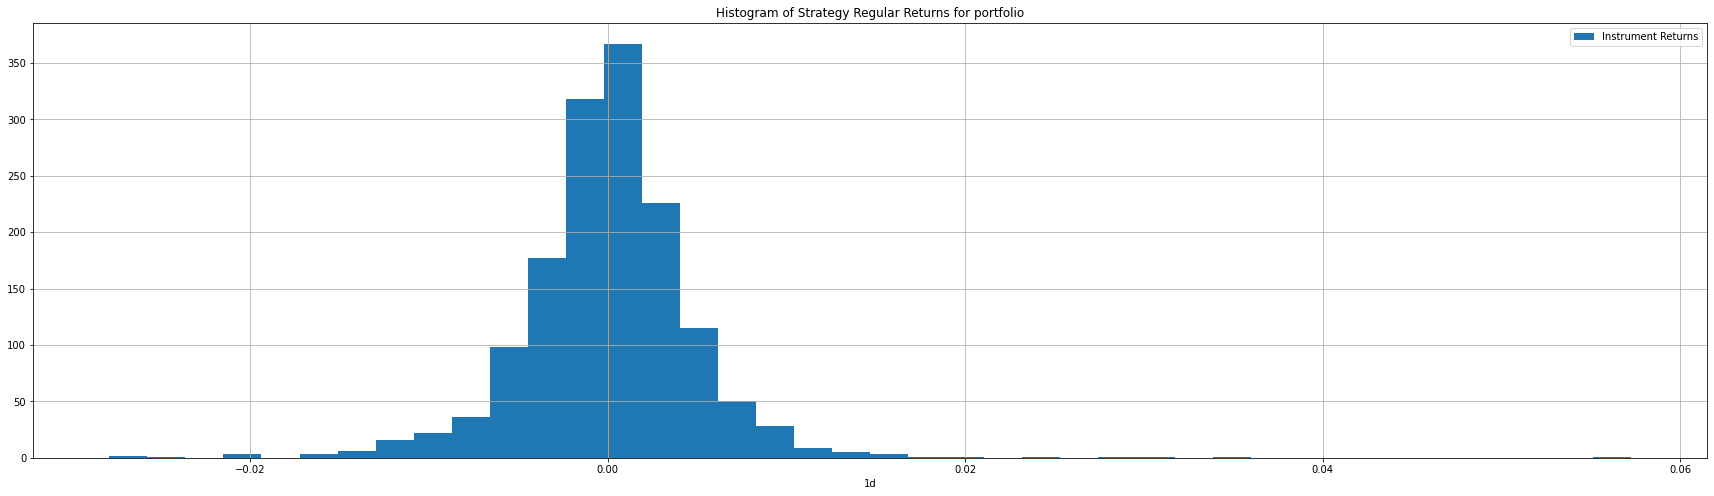

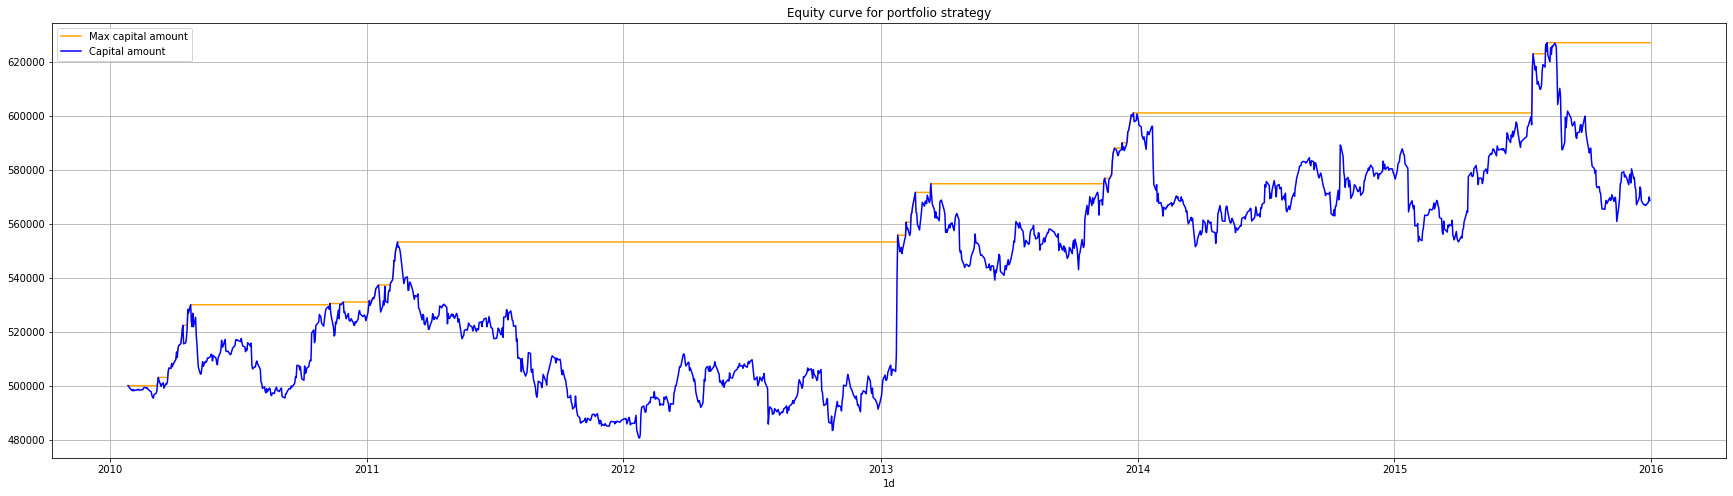

In [ ]:
A = BB_RSI_Strategy( ["DIS", "AAPL", "AMZN", "NFLX", "GOOG"], [0.2, 0.2, 0.2, 0.2, 0.2], 0.03, "2010-01-01", "2015-12-31","1d", 500000, 0.01, False)
A.run_strategy(14, 14, 40, 60, 14, 3)

### Second Iteration
Portfolio Equally Weighted, ATR_Multiplier = 1.5, Risk Tolerance = 3%

The total capital at end of strategy for DIS stock: 77536.38
The strategy returns for DIS stock are -22.46 %
Total trades by strategy for DIS stock is 61
The total capital at end of strategy for AAPL stock: 64398.49
The strategy returns for AAPL stock are -35.60 %
Total trades by strategy for AAPL stock is 72
The total capital at end of strategy for AMZN stock: 75052.45
The strategy returns for AMZN stock are -24.95 %
Total trades by strategy for AMZN stock is 66
The total capital at end of strategy for NFLX stock: 404940.68
The strategy returns for NFLX stock are 304.94 %
Total trades by strategy for NFLX stock is 46
The total capital at end of strategy for GOOG stock: 36427.40
The strategy returns for GOOG stock are -63.57 %
Total trades by strategy for GOOG stock is 86
============== Peformance of Strategy on Portfolio ==============
Annual Log Returns are:  0.0453
Annual Regular Returns are:  0.0464
Annual Benchmark Returns are:  0.1066
Annual Log Std Dev is:  0.1594
Annual Regular

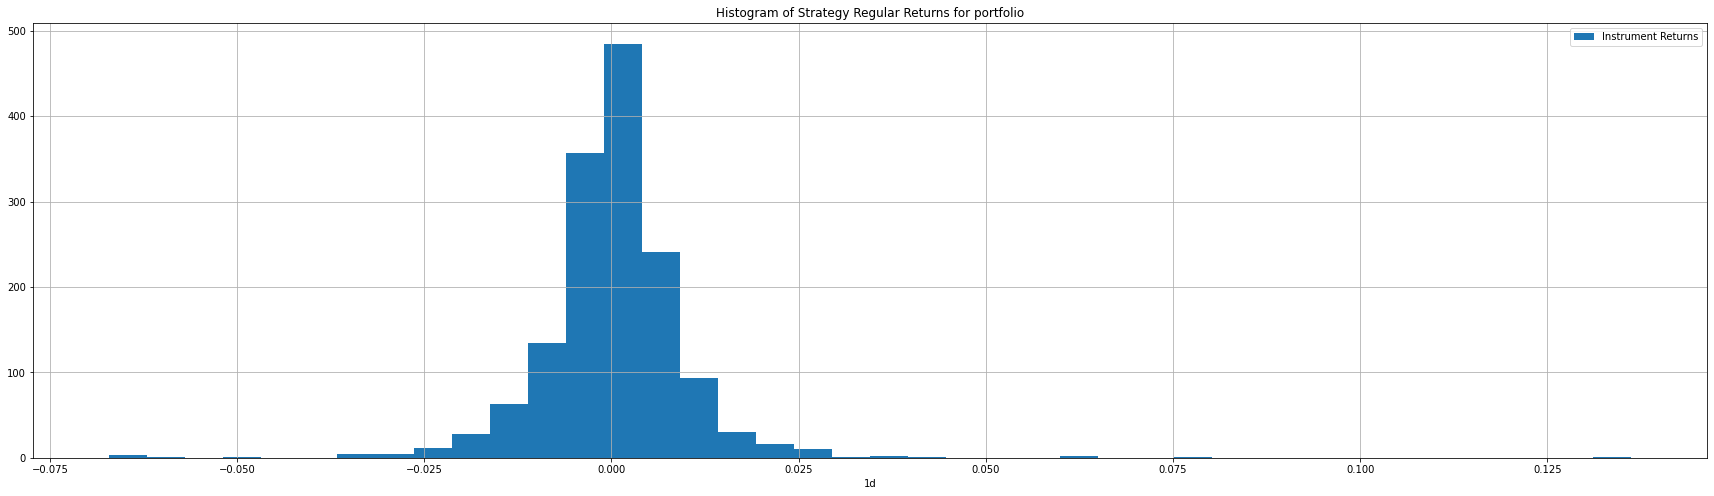

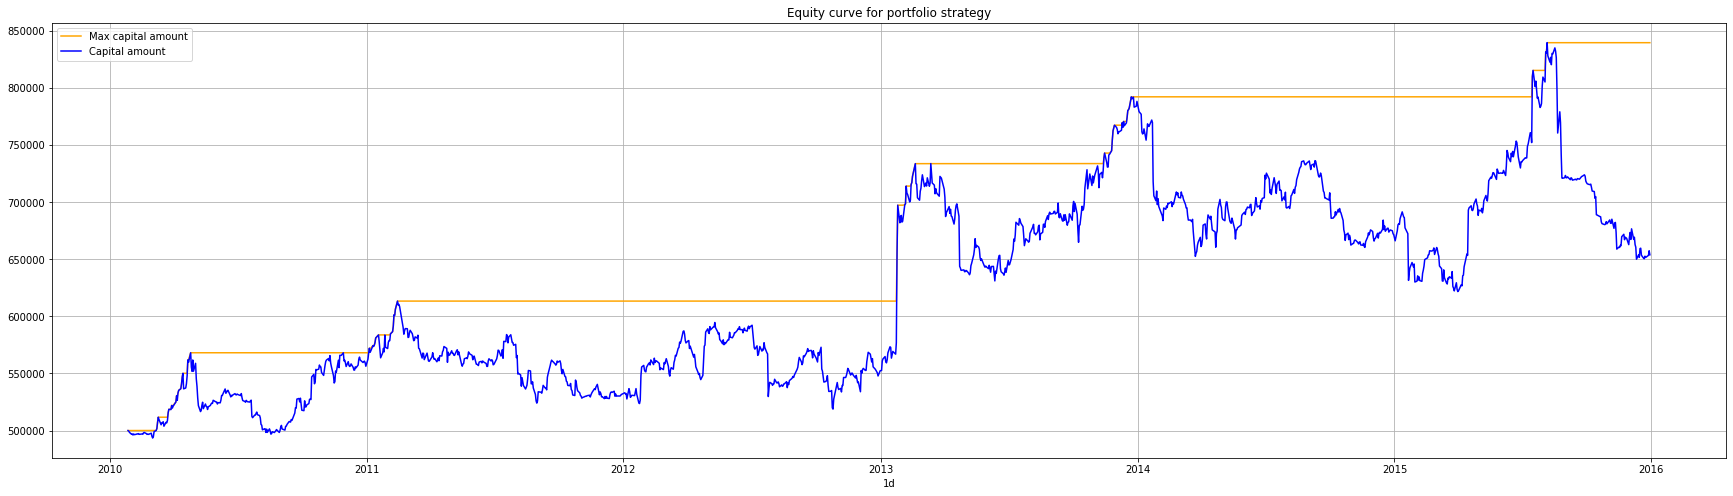

In [ ]:
A = BB_RSI_Strategy( ["DIS", "AAPL", "AMZN", "NFLX", "GOOG"], [0.2, 0.2, 0.2, 0.2, 0.2], 0.03, "2010-01-01", "2015-12-31","1d", 500000, 0.01, False)
A.run_strategy(14, 14, 40, 60, 14, 1.5)

### Third Iteration
Portfolio Equally Weighted, ATR_Multiplier = 0.5, Risk Tolerance = 3%

The total capital at end of strategy for DIS stock: 18010.16
The strategy returns for DIS stock are -81.99 %
Total trades by strategy for DIS stock is 83
The total capital at end of strategy for AAPL stock: 27582.75
The strategy returns for AAPL stock are -72.42 %
Total trades by strategy for AAPL stock is 84
The total capital at end of strategy for AMZN stock: 22807.05
The strategy returns for AMZN stock are -77.19 %
Total trades by strategy for AMZN stock is 94
The total capital at end of strategy for NFLX stock: 862533.46
The strategy returns for NFLX stock are 762.53 %
Total trades by strategy for NFLX stock is 73
The total capital at end of strategy for GOOG stock: 2725.12
The strategy returns for GOOG stock are -97.27 %
Total trades by strategy for GOOG stock is 114
============== Peformance of Strategy on Portfolio ==============
Annual Log Returns are:  0.1069
Annual Regular Returns are:  0.1128
Annual Benchmark Returns are:  0.1066
Annual Log Std Dev is:  0.5072
Annual Regular

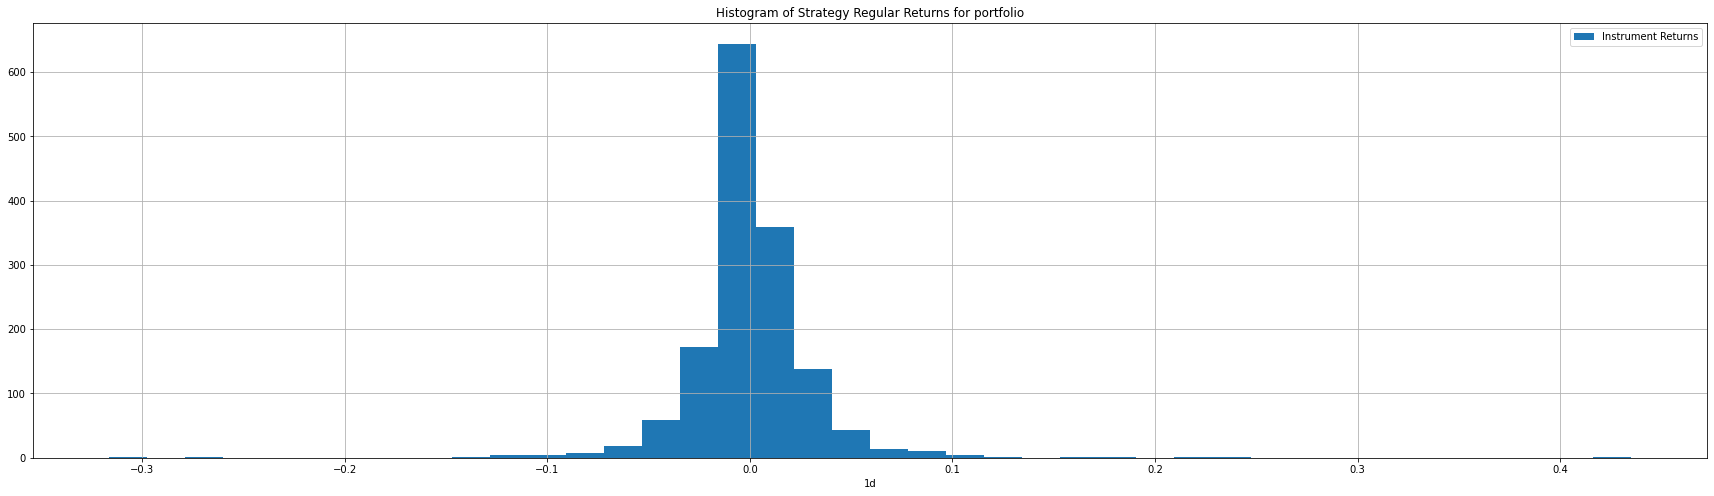

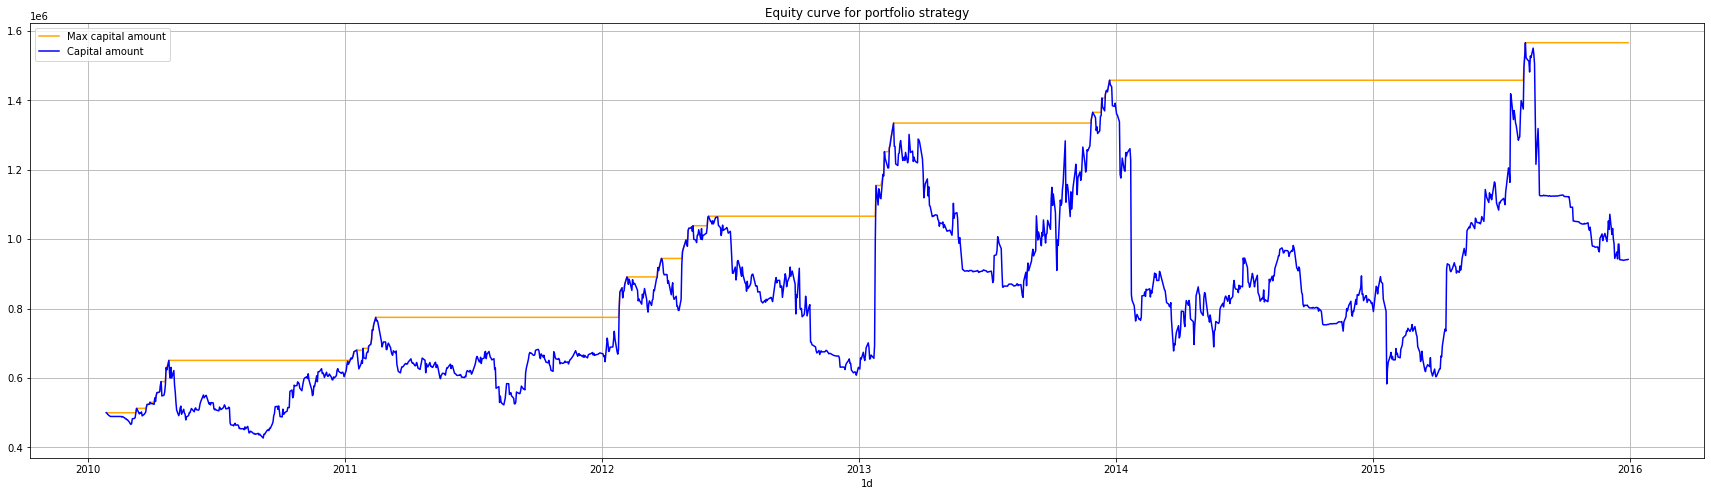

In [ ]:
A = BB_RSI_Strategy( ["DIS", "AAPL", "AMZN", "NFLX", "GOOG"], [0.2, 0.2, 0.2, 0.2, 0.2], 0.03, "2010-01-01", "2015-12-31","1d", 500000, 0.01, False)
A.run_strategy(14, 14, 40, 60, 14, 0.5)

### Fourth Iteration
Portfolio Equally Weighted, ATR_Multiplier = 0.5, Risk Tolerance = 6%

The total capital at end of strategy for DIS stock: 1458.74
The strategy returns for DIS stock are -98.54 %
Total trades by strategy for DIS stock is 83
The total capital at end of strategy for AAPL stock: 2662.60
The strategy returns for AAPL stock are -97.34 %
Total trades by strategy for AAPL stock is 84
The total capital at end of strategy for AMZN stock: 2654.54
The strategy returns for AMZN stock are -97.35 %
Total trades by strategy for AMZN stock is 94
The total capital at end of strategy for NFLX stock: 873669.29
The strategy returns for NFLX stock are 773.67 %
Total trades by strategy for NFLX stock is 73
The total capital at end of strategy for GOOG stock: 30.56
The strategy returns for GOOG stock are -99.97 %
Total trades by strategy for GOOG stock is 114
============== Peformance of Strategy on Portfolio ==============
Annual Log Returns are:  0.0959
Annual Regular Returns are:  0.1006
Annual Benchmark Returns are:  0.1066
Annual Log Std Dev is:  1.0475
Annual Regular Std 

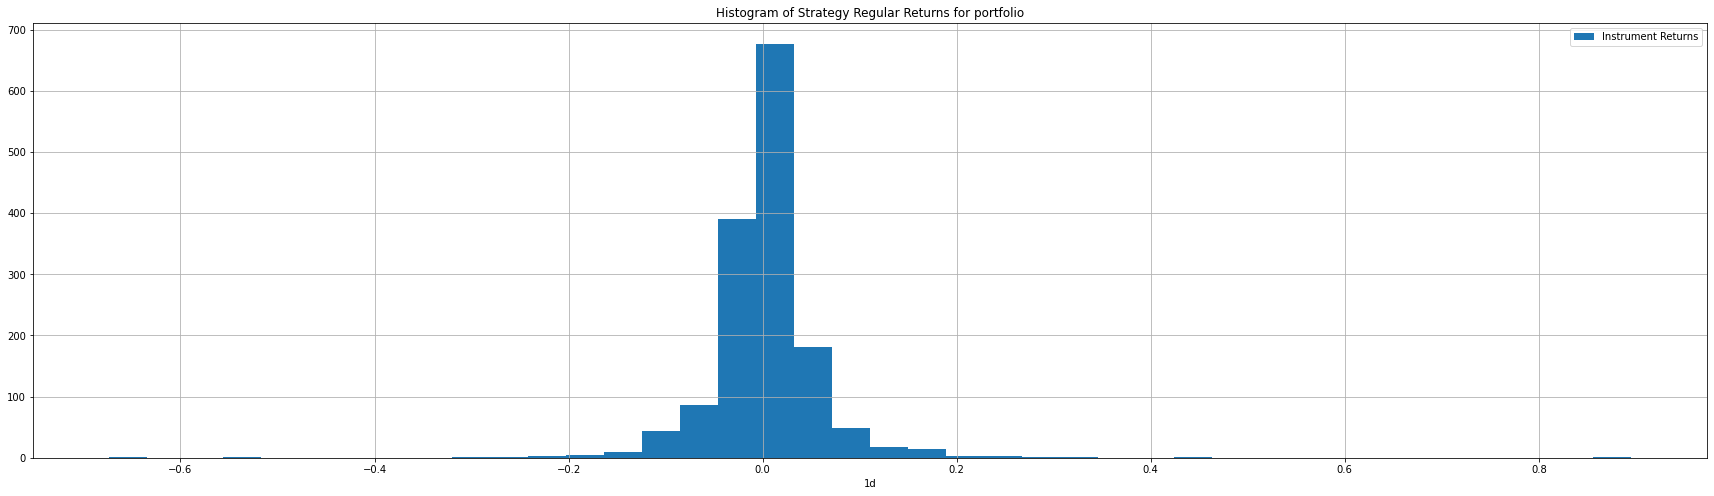

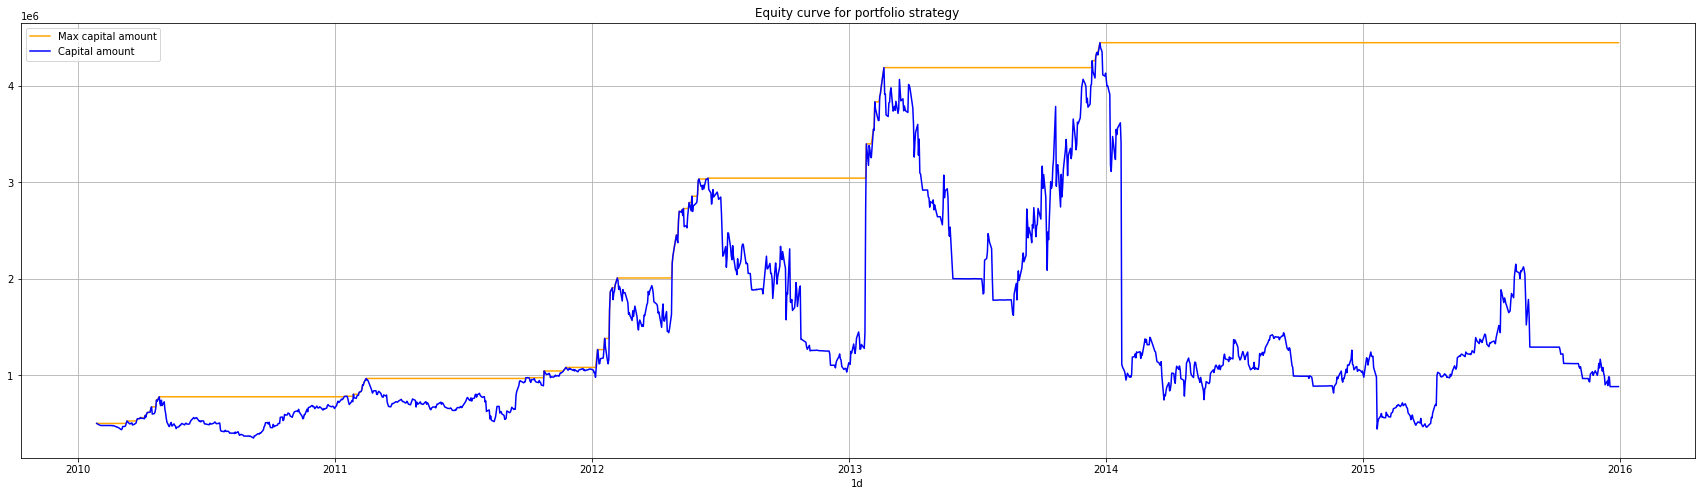

In [ ]:
A = BB_RSI_Strategy( ["DIS", "AAPL", "AMZN", "NFLX", "GOOG"], [0.2, 0.2, 0.2, 0.2, 0.2], 0.06, "2010-01-01", "2015-12-31","1d", 500000, 0.01, False)
A.run_strategy(14, 14, 40, 60, 14, 0.5)

### Fifth Iteration
Portfolio Equally Weighted, ATR_Multiplier = 0.5, Risk Tolerance = 9%

The total capital at end of strategy for DIS stock: 50.40
The strategy returns for DIS stock are -99.95 %
Total trades by strategy for DIS stock is 83
The total capital at end of strategy for AAPL stock: 106.11
The strategy returns for AAPL stock are -99.89 %
Total trades by strategy for AAPL stock is 84
The total capital at end of strategy for AMZN stock: 172.48
The strategy returns for AMZN stock are -99.83 %
Total trades by strategy for AMZN stock is 94
The total capital at end of strategy for NFLX stock: 23876.37
The strategy returns for NFLX stock are -76.12 %
Total trades by strategy for NFLX stock is 73
The total capital at end of strategy for GOOG stock: 0.11
The strategy returns for GOOG stock are -100.00 %
Total trades by strategy for GOOG stock is 114
============== Peformance of Strategy on Portfolio ==============
Annual Log Returns are:  -0.5106
Annual Regular Returns are:  -0.3999
Annual Benchmark Returns are:  0.1066
Annual Log Std Dev is:  2.2147
Annual Regular Std Dev

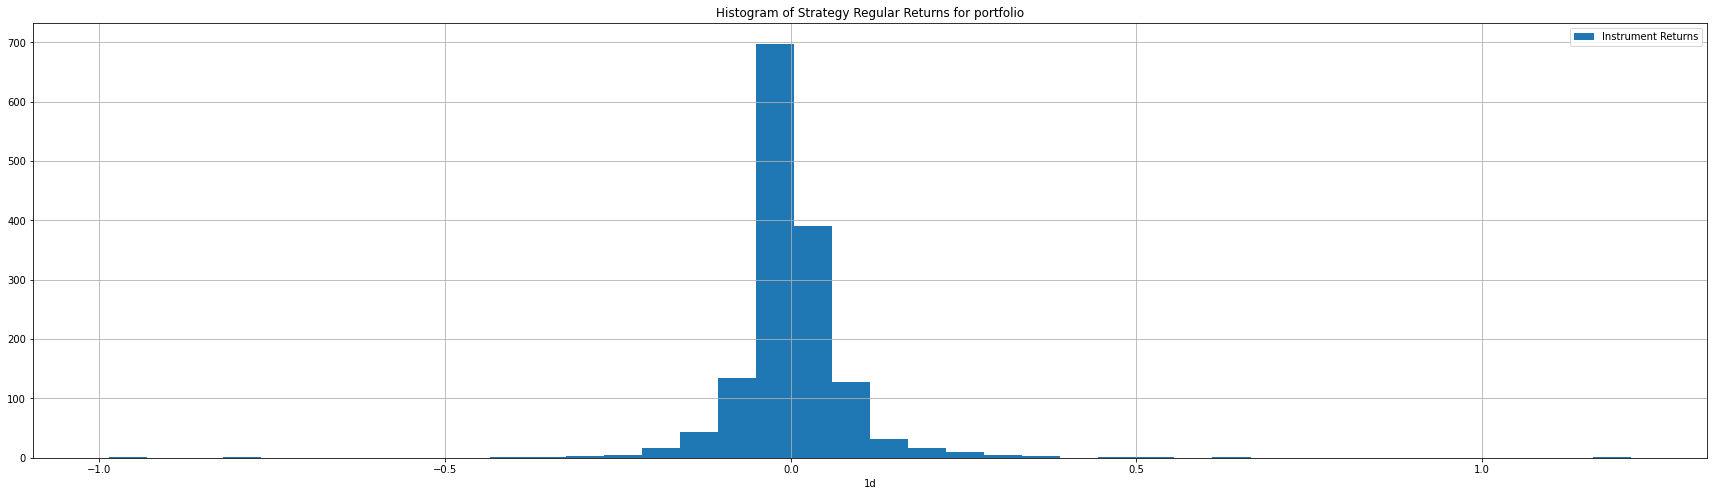

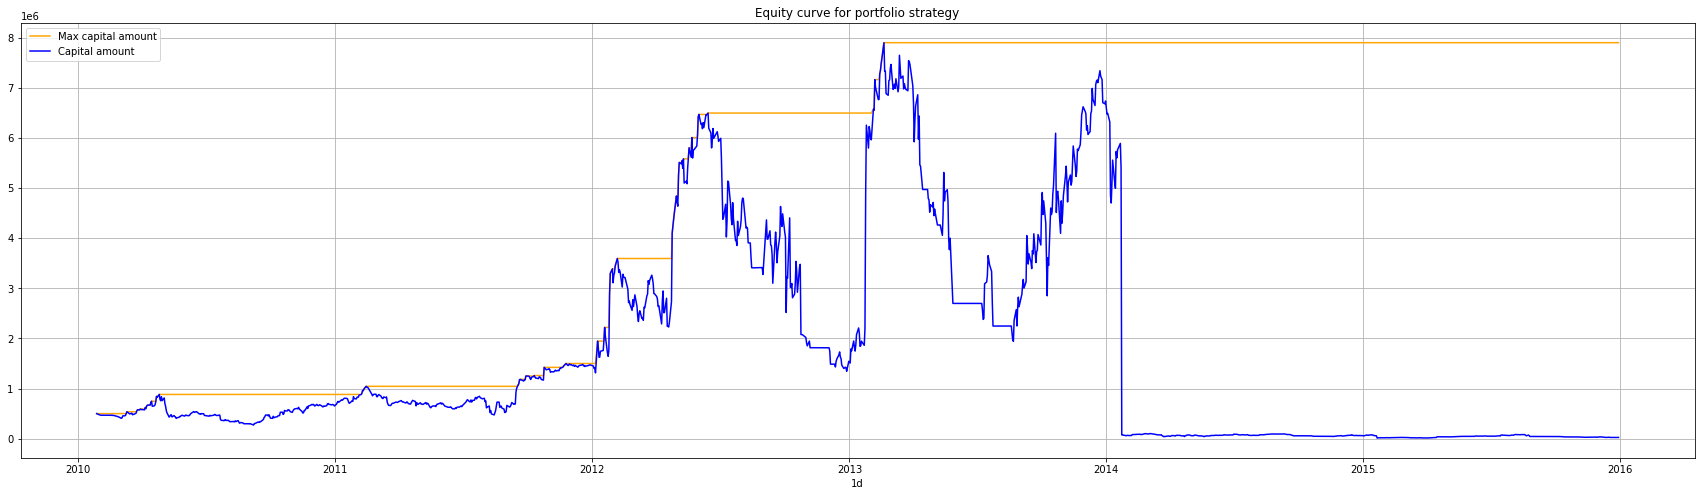

In [ ]:
A = BB_RSI_Strategy( ["DIS", "AAPL", "AMZN", "NFLX", "GOOG"], [0.2, 0.2, 0.2, 0.2, 0.2], 0.09, "2010-01-01", "2015-12-31","1d", 500000, 0.01, False)
A.run_strategy(14, 14, 40, 60, 14, 0.5)

### Sixth Iteration
Portfolio Not Equally Weighted, ATR_Multiplier = 0.5, Risk Tolerance = 3%

The total capital at end of strategy for DIS stock: 13507.71
The strategy returns for DIS stock are -81.99 %
Total trades by strategy for DIS stock is 83
The total capital at end of strategy for AAPL stock: 27582.47
The strategy returns for AAPL stock are -72.42 %
Total trades by strategy for AAPL stock is 84
The total capital at end of strategy for AMZN stock: 22807.05
The strategy returns for AMZN stock are -77.19 %
Total trades by strategy for AMZN stock is 94
The total capital at end of strategy for NFLX stock: 1293800.19
The strategy returns for NFLX stock are 762.53 %
Total trades by strategy for NFLX stock is 73
The total capital at end of strategy for GOOG stock: 2043.84
The strategy returns for GOOG stock are -97.27 %
Total trades by strategy for GOOG stock is 114
============== Peformance of Strategy on Portfolio ==============
Annual Log Returns are:  0.17
Annual Regular Returns are:  0.1853
Annual Benchmark Returns are:  0.1066
Annual Log Std Dev is:  0.5377
Annual Regular 

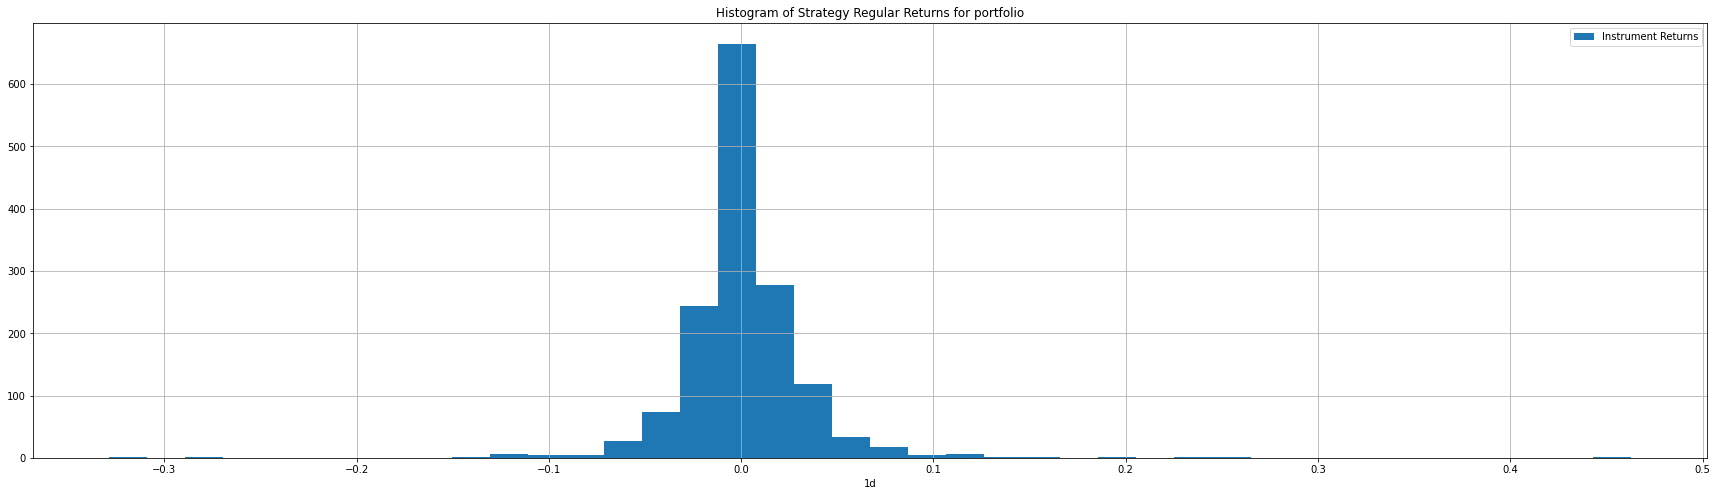

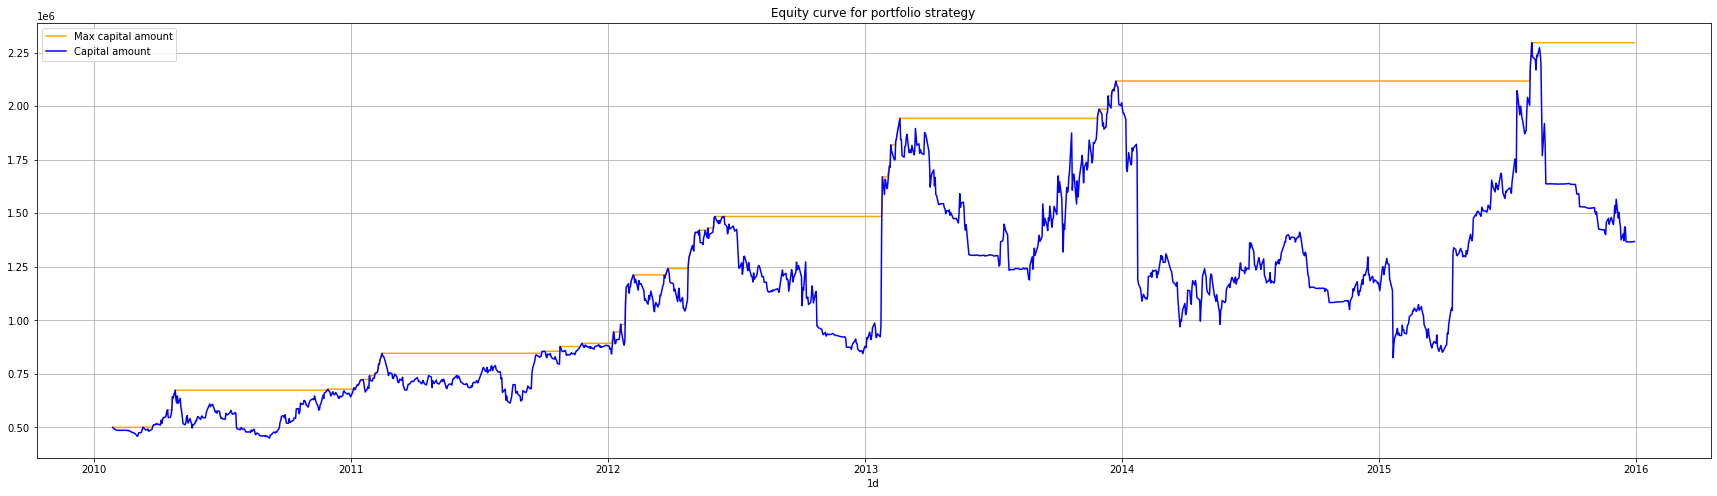

In [ ]:
A = BB_RSI_Strategy( ["DIS", "AAPL", "AMZN", "NFLX", "GOOG"], [0.15, 0.2, 0.2, 0.3, 0.15], 0.03, "2010-01-01", "2015-12-31","1d", 500000, 0.01, False)
A.run_strategy(14, 14, 40, 60, 14, 0.5)

## Testing
Portfolio Not Equally Weighted, ATR_Multiplier = 0.5, Risk Tolerance = 3%

The total capital at end of strategy for DIS stock: 29499.87
The strategy returns for DIS stock are -60.67 %
Total trades by strategy for DIS stock is 62
The total capital at end of strategy for AAPL stock: 20120.91
The strategy returns for AAPL stock are -79.88 %
Total trades by strategy for AAPL stock is 78
The total capital at end of strategy for AMZN stock: 182770.37
The strategy returns for AMZN stock are 82.77 %
Total trades by strategy for AMZN stock is 59
The total capital at end of strategy for NFLX stock: 84408.12
The strategy returns for NFLX stock are -43.73 %
Total trades by strategy for NFLX stock is 82
The total capital at end of strategy for GOOG stock: 5750.92
The strategy returns for GOOG stock are -92.33 %
Total trades by strategy for GOOG stock is 84
============== Peformance of Strategy on Portfolio ==============
Annual Log Returns are:  -0.0771
Annual Regular Returns are:  -0.0742
Annual Benchmark Returns are:  0.0939
Annual Log Std Dev is:  0.3649
Annual Regular

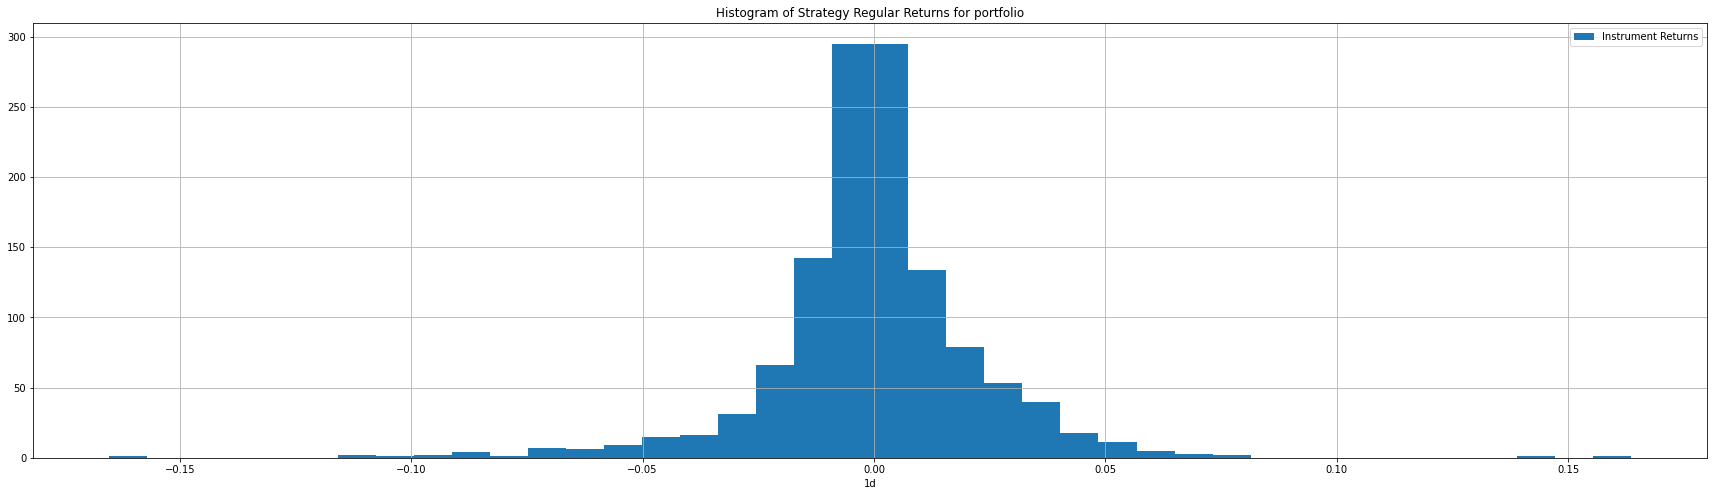

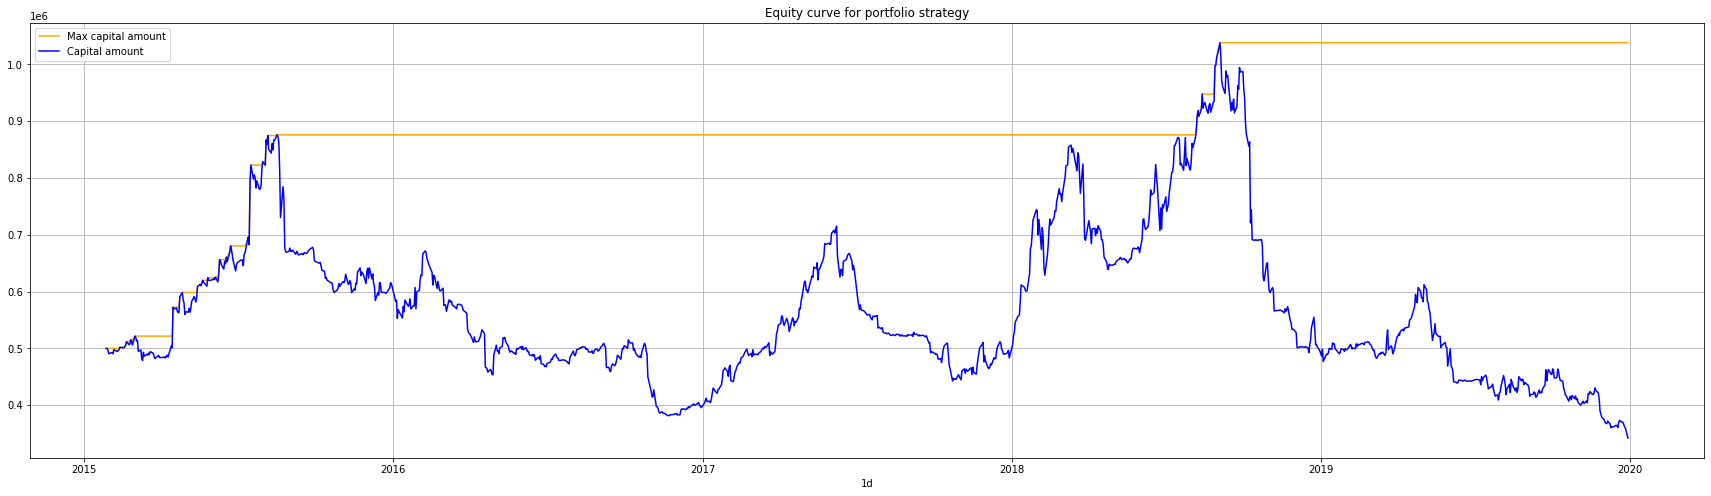

In [ ]:
if __name__ == "__main__":
  A = BB_RSI_Strategy( ["DIS", "AAPL", "AMZN", "NFLX", "GOOG"], [0.15, 0.2, 0.2, 0.3, 0.15], 0.03, "2015-01-01", "2019-12-31","1d", 500000, 0.01, False)
  A.run_strategy(14, 14, 40, 60, 14, 0.5)